In [1]:
import netCDF4 as nc
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

In [3]:
#Identify scanline in groundpixel 224 with clouds
scanline = africa.variables['scanline']
groundpixel = africa.variables['ground_pixel']

#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud = []
for n in range(406):
    if (africa.variables['CloudFraction'][0,n,224:240]<0.4).all():
        scanline_nocloud.append(n)

In [4]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 4 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), 195))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

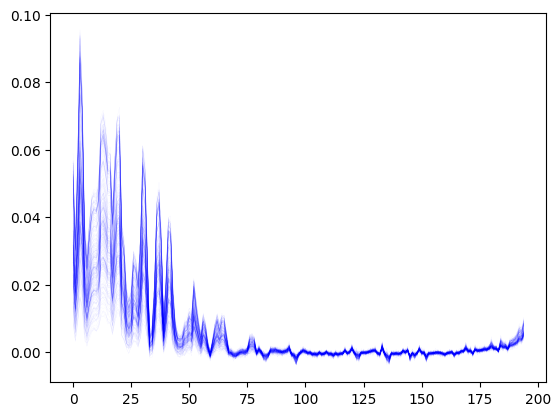

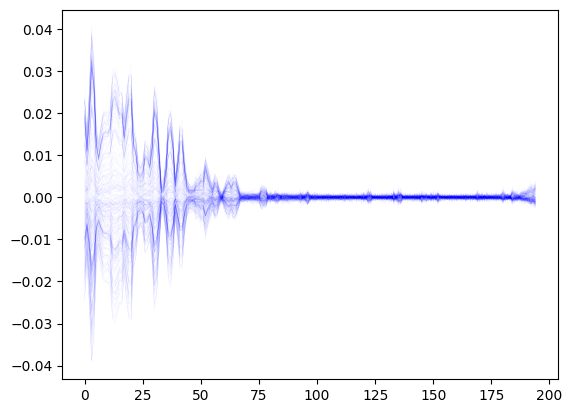

Centered data shape: (317, 195)
Mean after centering: 3.3030886123015795e-17


In [5]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,224]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,224]))
mu_matrix = np.tile(mu[:, np.newaxis], 195)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 195)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 224, 276:471].data
angles = (mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix
tau = -np.log(reflectance_matrix/surf_albedo)/angles

for idx, i  in enumerate(scanline_nocloud):
    plt.plot(tau[idx],color='blue', alpha=0.1, linewidth=0.1)
    #what is the unit?? 
plt.show()

# Center data
mean_spectrum = np.mean(tau, axis=0)
tau_centered = tau - mean_spectrum
for idx, i  in enumerate(scanline_nocloud):
    plt.plot(tau_centered[idx],color='blue', alpha=0.1, linewidth=0.1)
    #what is the unit?? 
plt.show()

# Verify
print("Centered data shape:", tau_centered.shape)
print("Mean after centering:", np.mean(tau_centered, axis=0).max())  # Should be ~0

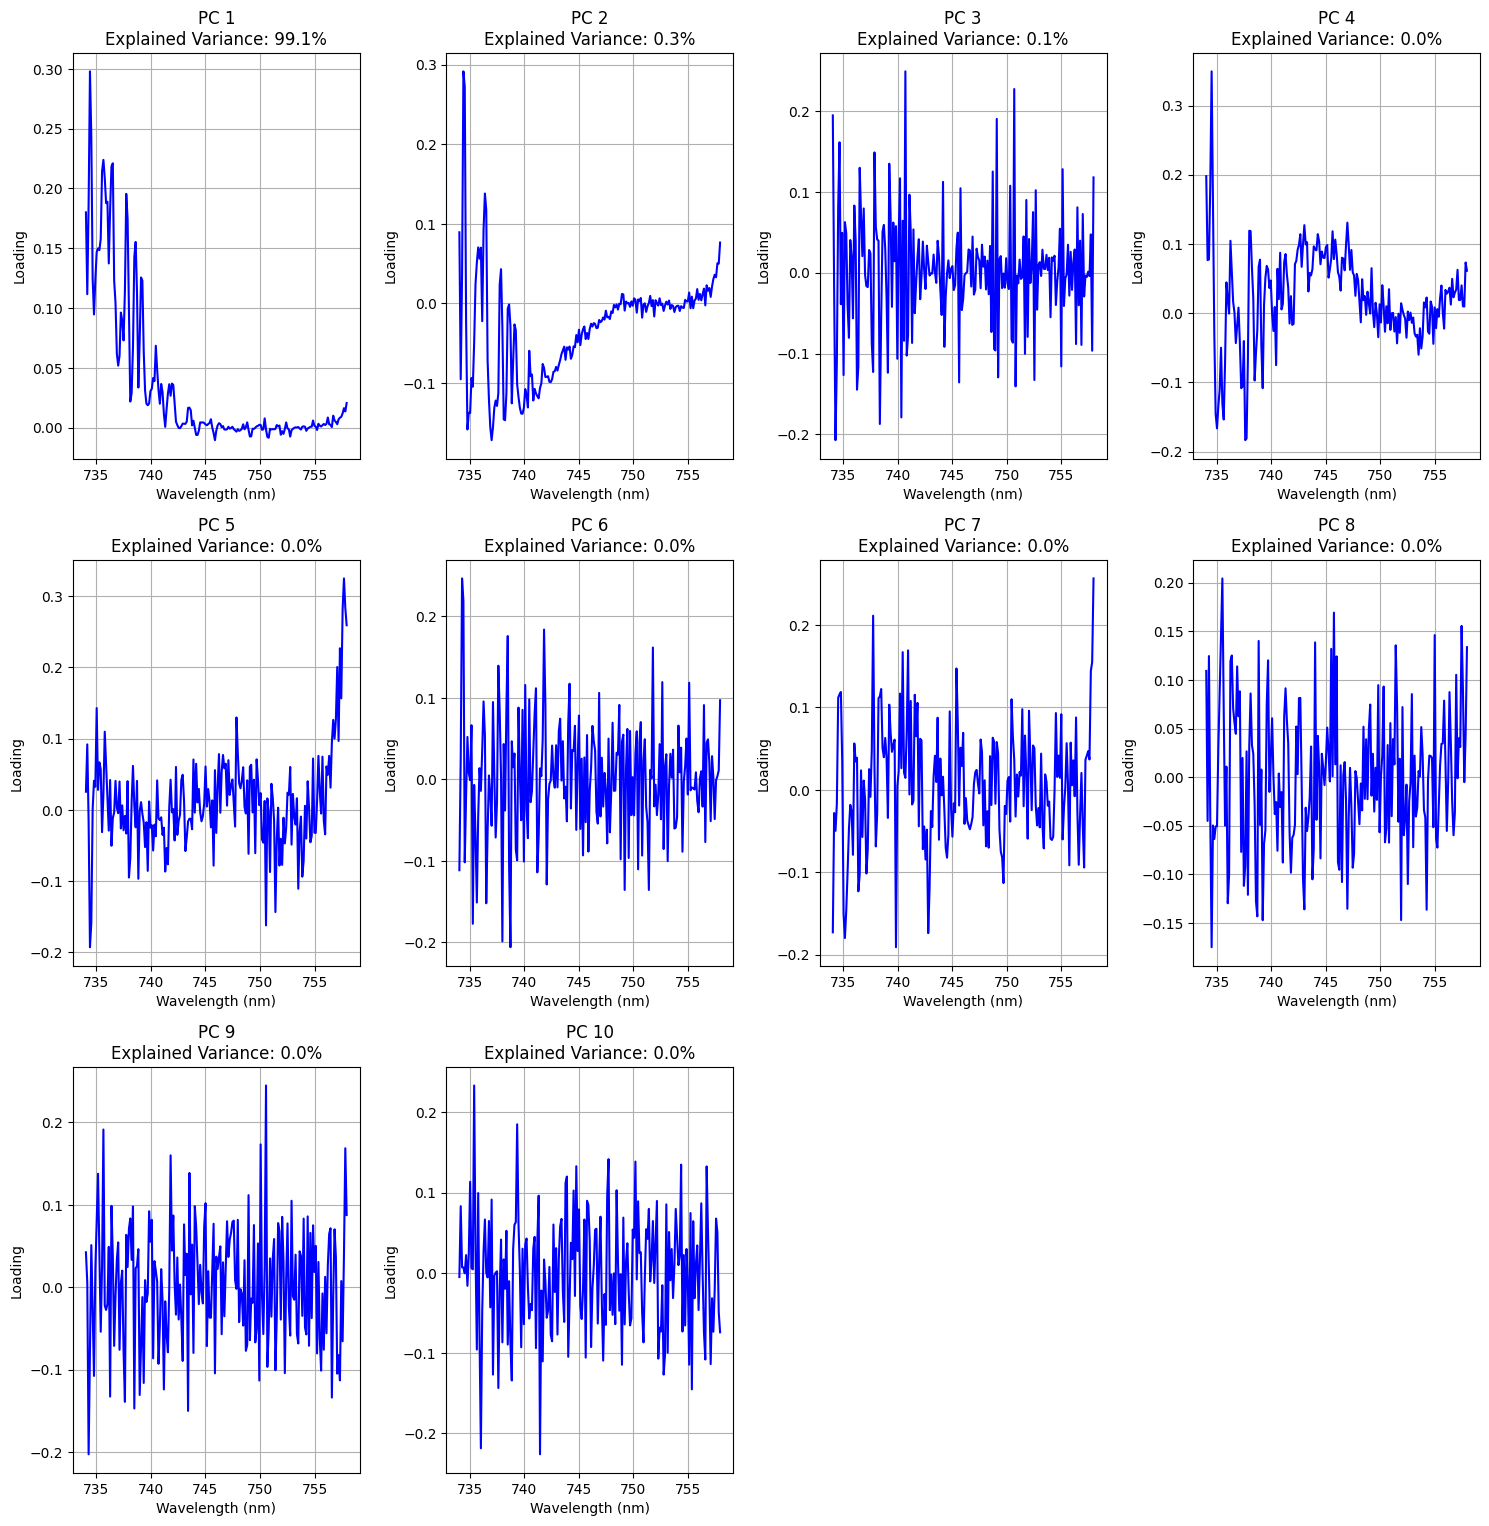

PCA Cumulative Variance: 0.9962081698871841


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(tau_centered)
components = pca.components_
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(4, 4, i+1)  # 4x4 grid
    plt.plot(wl[ind], components[i], color='blue')
    plt.title(f'PC {i+1}\nExplained Variance: {pca.explained_variance_ratio_[i]*100:.1f}%')
    plt.xlabel("Feature Index" if wl[ind] is None else "Wavelength (nm)")
    plt.ylabel("Loading")
    plt.grid(True)
plt.tight_layout()
plt.show()
print("PCA Cumulative Variance:", np.sum(pca.explained_variance_ratio_))

In [7]:
##SIF-retrieval 

In [8]:
#SOLAR IRRADIANCE FROM ? 
E = nc.Dataset('S5P_OPER_REF_SOLAR__00000000T000000_99999999T999999_20210107T132455.nc')
groups = E.groups
E_0 = E.groups['band_6']

wavelength = E_0["wavelength"][:]
indices = np.where((wavelength >= 734) & (wavelength <= 758))[0]
# Get irradiance_flux and subset the desired range
irradiance_flux = E_0["irradiance_flux_cf"][0, indices]
num_pixels = len(irradiance_flux)
target_size = 195
step = num_pixels // target_size  
# Average over non-overlapping groups of ground pixels
irradiance_vector = np.squeeze(np.mean(irradiance_flux[:step*target_size].reshape(target_size, step, -1), axis=1))

#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
            """
            Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹.
           
            Parameters:
                irradiance_mol (array): Irradiance in mol s⁻¹ m⁻² nm⁻¹
                wavelength_nm (array): Corresponding wavelengths in nm
               
            Returns:
                array: Irradiance in W m⁻² nm⁻¹
            """
            # Constants
            h = 6.626e-34  # Planck's constant (J·s)
            c = 2.998e8    # Speed of light (m/s)
            Na = 6.022e23  # Avogadro's number (photons/mol)
           
            wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to meters
            photon_energy = (h * c) / wavelength_m  # Energy per photon in Joules
            irradiance_watts = irradiance_mol * Na * photon_energy  # Convert to W/m²/nm
       
            # # Print a value before and after conversion
            # index = 0  # View the first value
            # print(f"Before: {irradiance_mol[index]:.5e} mol/s/m²/nm at {wavelength_nm[index]} nm")
            # print(f"After:  {irradiance_watts[index]:.5f} W/m²/nm at {wavelength_nm[index]} nm")
       
            return irradiance_watts
       
solspec = convert_irradiance(irradiance_vector, wl[ind])

(10, 195)
Fitted parameters:
[ 1.63627253e-01  1.06615990e-02 -6.71026528e-04 -1.60404392e-04
  4.05990617e-03  1.38784156e-04 -1.02378964e-03  1.90831498e-03
  3.49471737e-04  9.02873323e-04 -2.46720158e-06]
-2.4672015780512703e-06


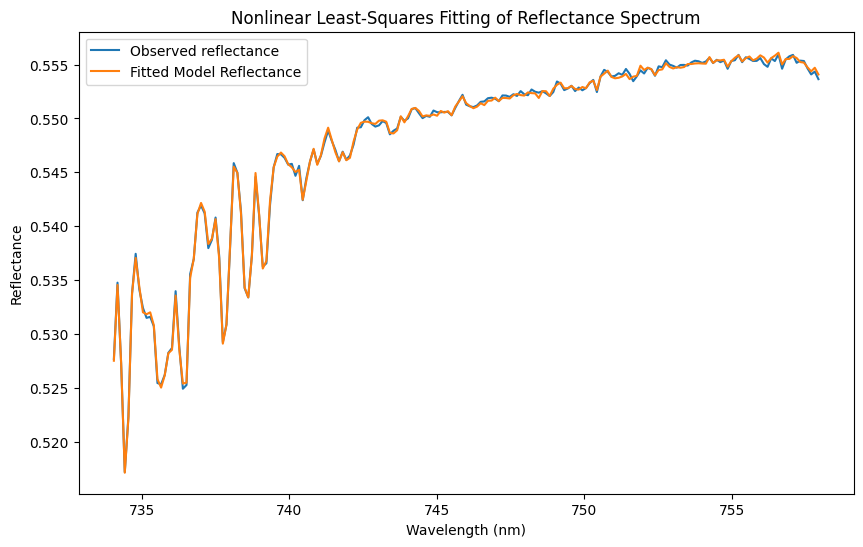

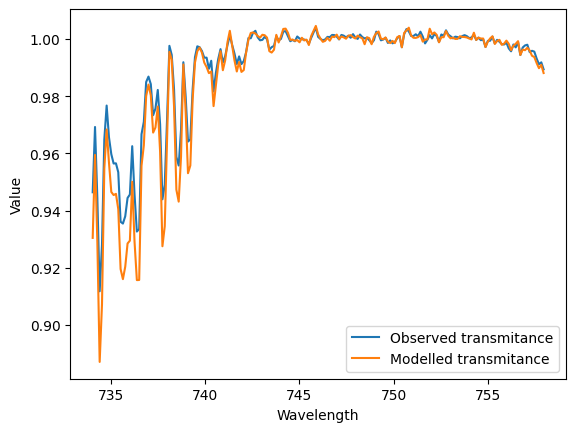

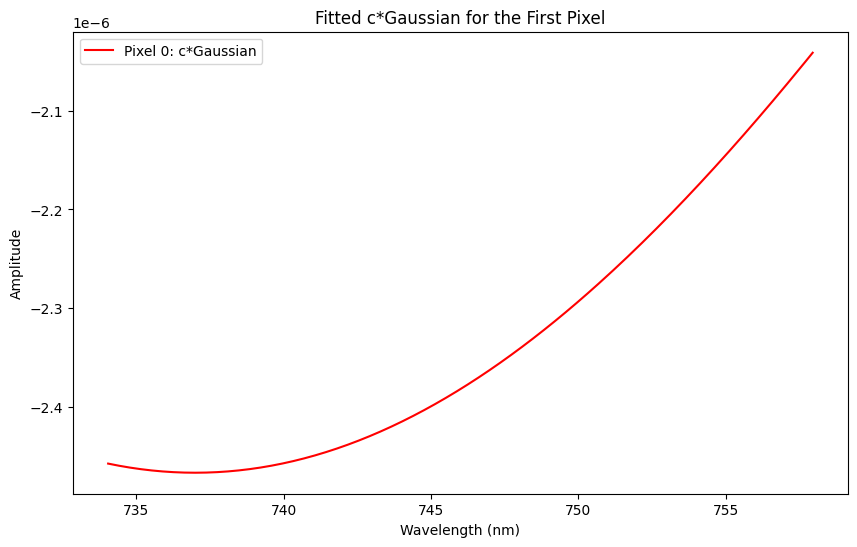

In [19]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
reflectance_observed = africa.variables['Reflectance'][0, scanline_nocloud[100], 224, 276:471].data
pixel_index = 100
def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = surf_albedo[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix[pixel_index]) / ((1 / mu_matrix[pixel_index]) + (1 / mu_0_matrix[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [-0.5]
# Fit the model to the observed reflectance
popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)

print("Fitted parameters:")
print(popt)
print(popt[n])
# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))*tau)[100]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix[100]) + np.reciprocal(mu_0_matrix[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[0]}: c*Gaussian", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted c*Gaussian for the First Pixel")
plt.legend()
plt.show()


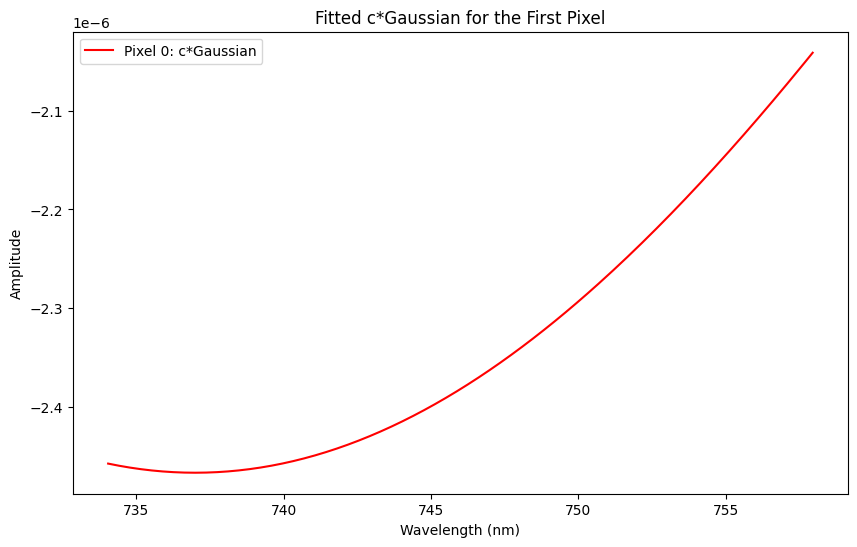

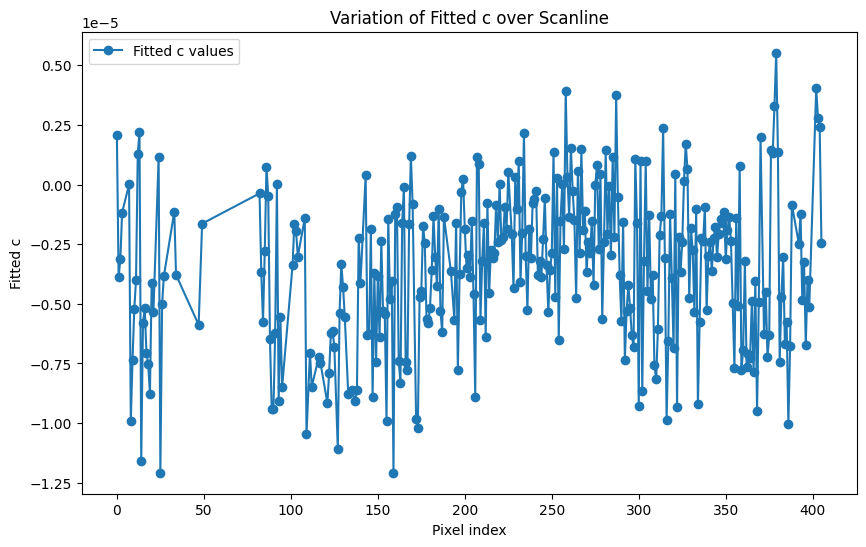

-2.4672015780512703e-06


In [20]:
# Prepare an array to store the fitted c_gaussian for each pixel.
# We'll store the full vector for each pixel in a list.
c_gaussian_list = []  
fitted_c_list = []   # Optionally store just the fitted c value for each pixel

# Loop over each pixel index in your scanline (assuming scanline_nocloud is an array of pixel indices)
for pixel_index, i in enumerate(scanline_nocloud):
    # Extract the reflectance spectrum for this pixel. Adjust indices as necessary.
    # Here we assume the reflectance array has dimensions [time, scanline, row, column]
    # and that 'pixel_index' indexes the spatial dimension you wish to loop over.
    reflectance_observed = africa.variables['Reflectance'][0, i, 224, 276:471].data

    try:
        # Fit the model to the observed reflectance
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)
        
        # Extract the fitted parameter c (index 10)
        fitted_c = popt[n]
        fitted_c_list.append(fitted_c)
        
        # Compute c * gaussian for the current pixel over the wavelength range
        c_gaussian = fitted_c * gaussian_full
        
        # Append the computed vector to the list
        c_gaussian_list.append(c_gaussian)
        
    except Exception as e:
        print(f"Fit failed for pixel {pixel_index}: {e}")
        # Append NaN array to preserve index if needed
        c_gaussian_list.append(np.full_like(gaussian_full, np.nan))
        fitted_c_list.append(np.nan)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], c_gaussian_list[100], label=f"Pixel {scanline_nocloud[0]}: c*Gaussian", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted c*Gaussian for the First Pixel")
plt.legend()
plt.show()

# Optionally, if you want to visualize how the fitted c values vary over the scanline:
plt.figure(figsize=(10, 6))
plt.plot(scanline_nocloud, fitted_c_list, 'o-', label="Fitted c values")
plt.xlabel("Pixel index")
plt.ylabel("Fitted c")
plt.title("Variation of Fitted c over Scanline")
plt.legend()
plt.show()
print(fitted_c_list[100])

In [10]:
h2 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T172817_20240206T173755_32735_93_000001_20241120T172637.nc')
africa2 = h2.groups['africa']

In [11]:
#Identify scanline in groundpixel 224 with clouds
scanline2 = africa2.variables['scanline']
groundpixel2 = africa2.variables['ground_pixel']
scanline_nocloud2 = []
for n in range(406):
    if africa2.variables['CloudFraction'][0,n,224]<0.5:
        scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#sc_nc > sc_nc2

#Fixing albedo 

ref_na2 = africa2.variables["Reflectance"][0, scanline_nocloud2, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 195))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb + 0.007

#Computing tau
mu2 = np.cos(np.radians(africa2.variables["VZA"][0,scanline_nocloud2,224]))
mu_02 = np.cos(np.radians(africa2.variables["SZA"][0,scanline_nocloud2,224]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,195))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 195))
reflectance_matrix2 = africa2.variables['Reflectance'][0, scanline_nocloud2, 224, 276:471]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))
irradiance_matrix2 = np.tile(solspec.T, (len(scanline_nocloud2), 1))

(10, 195)
Fitted parameters:
[ 0.69782569  0.12853935 -0.00896018 -0.10738052  0.05665472  0.00340861
  0.02142775  0.00583289 -0.00632517 -0.01346834 -0.04280487]


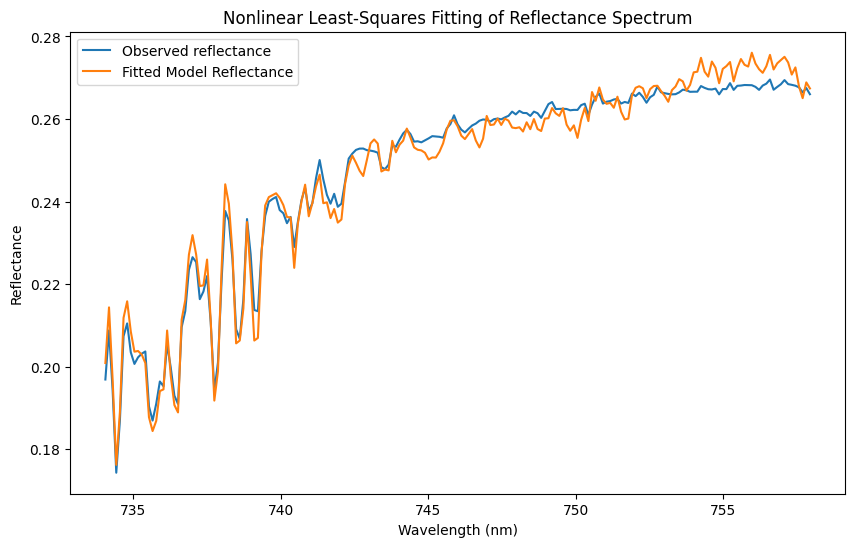

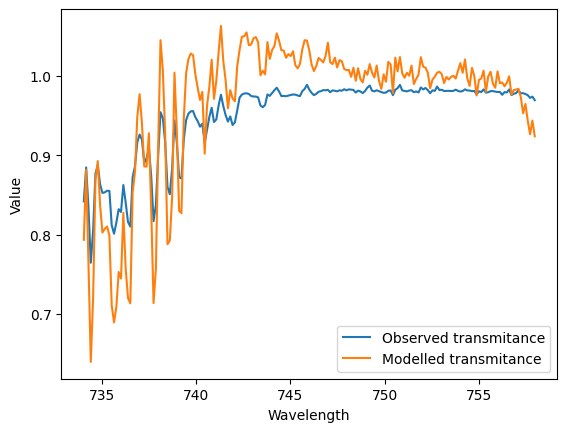

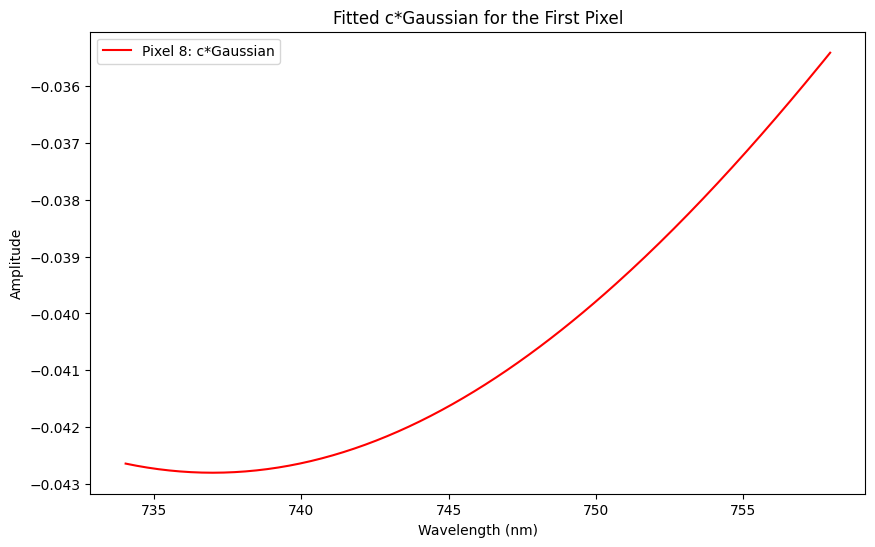

In [24]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
reflectance_observed = africa2.variables['Reflectance'][0, 100, 224, 276:471].data
pixel_index = 100
def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [0.5]
# Fit the model to the observed reflectance
popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)


# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[0]}: c*Gaussian", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted c*Gaussian for the First Pixel")
plt.legend()
plt.show()


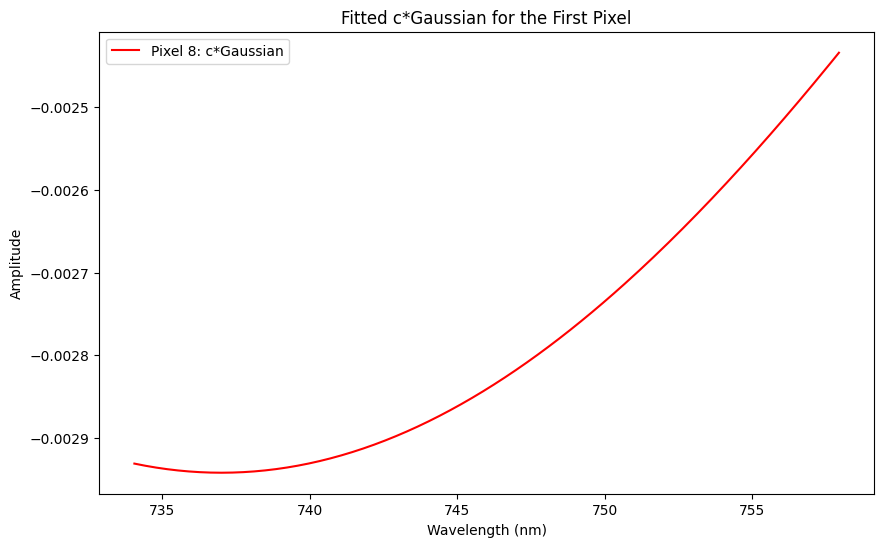

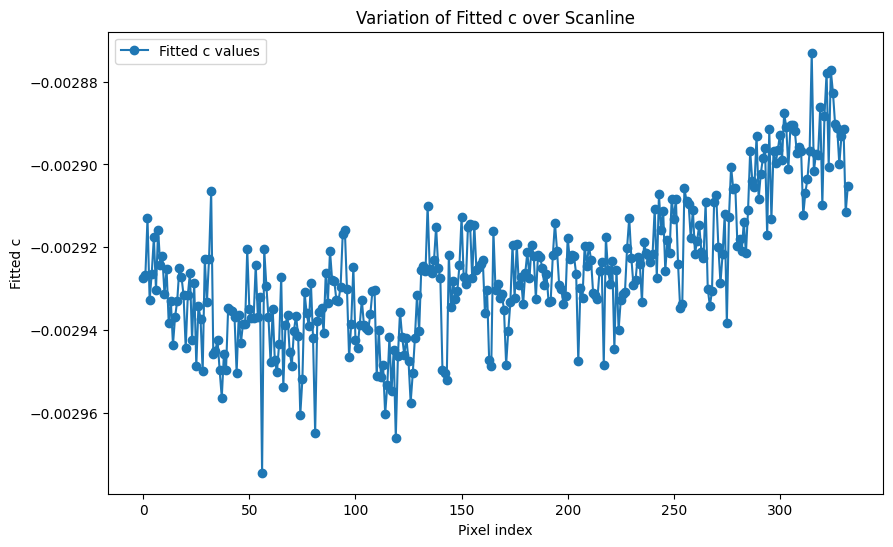

In [23]:
# Prepare an array to store the fitted c_gaussian for each pixel.
# We'll store the full vector for each pixel in a list.
c_gaussian_list = []  
fitted_c_list = []   # Optionally store just the fitted c value for each pixel

# Loop over each pixel index in your scanline (assuming scanline_nocloud is an array of pixel indices)
for pixel_index, i in enumerate(scanline_nocloud2):
    # Extract the reflectance spectrum for this pixel. Adjust indices as necessary.
    # Here we assume the reflectance array has dimensions [time, scanline, row, column]
    # and that 'pixel_index' indexes the spatial dimension you wish to loop over.
    reflectance_observed = africa2.variables['Reflectance'][0, i, 224, 276:471].data

    try:
        # Fit the model to the observed reflectance
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)
        
        # Extract the fitted parameter c (index 10)
        fitted_c = popt[-1]
        fitted_c_list.append(fitted_c)
        
        # Compute c * gaussian for the current pixel over the wavelength range
        c_gaussian = fitted_c * gaussian_full
        
        # Append the computed vector to the list
        c_gaussian_list.append(c_gaussian)
        
    except Exception as e:
        print(f"Fit failed for pixel {pixel_index}: {e}")
        # Append NaN array to preserve index if needed
        c_gaussian_list.append(np.full_like(gaussian_full, np.nan))
        fitted_c_list.append(np.nan)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], c_gaussian_list[100], label=f"Pixel {scanline_nocloud2[100]}: c*Gaussian", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted c*Gaussian for the First Pixel")
plt.legend()
plt.show()

# Optionally, if you want to visualize how the fitted c values vary over the scanline:
plt.figure(figsize=(10, 6))
plt.plot(fitted_c_list, 'o-', label="Fitted c values")
plt.xlabel("Pixel index")
plt.ylabel("Fitted c")
plt.title("Variation of Fitted c over Scanline")
plt.legend()
plt.show()